In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam

In [3]:
# Select the device to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [4]:
# Randomly init a tensor
a = torch.randn(size=(128, 1, 28, 28), dtype=torch.float32, device=device, requires_grad=False)

print(a.shape)

torch.Size([128, 1, 28, 28])


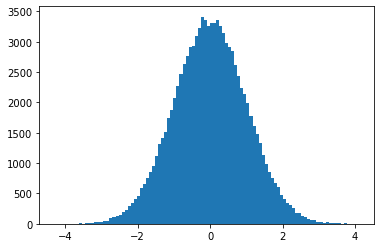

In [5]:
plt.hist(a.cpu().numpy().ravel(), bins=100);




# Linear Layer




In [6]:
# Create a linear layer 
neuron = nn.Linear(in_features=28*28, out_features=12, bias=True)

# Move the layer onto the GPU
neuron.to(device)

# Print some stuff
print(neuron)
print(type(neuron))
print(neuron.weight.shape, neuron.bias.shape)

Linear(in_features=784, out_features=12, bias=True)
<class 'torch.nn.modules.linear.Linear'>
torch.Size([12, 784]) torch.Size([12])


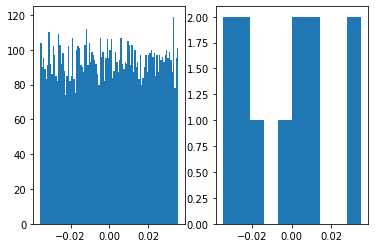

In [7]:
plt.subplot(1, 2, 1)
plt.hist(neuron.weight.detach().cpu().numpy().ravel(), bins=100);
plt.subplot(1, 2, 2)
plt.hist(neuron.bias.detach().cpu().numpy().ravel());
plt.show()

In [8]:
# Run the layer over the input tensor 'a'
output = neuron(a)

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [11]:
output = neuron(a.view(a.shape[0], -1))

In [12]:
print(output.shape)

torch.Size([128, 12])


In [13]:
print(output[:5, :3].detach().cpu().numpy())

[[-0.2454697   0.01491949  0.06926234]
 [ 0.5261362   0.76206005  0.3964377 ]
 [-0.21830006 -0.21805266  0.3938142 ]
 [-0.20999233 -0.10016773 -0.93600154]
 [ 1.3778194   0.30419672 -0.37339616]]


In [14]:
# Don't believe... VERIFY!!!
W = neuron.weight.data.clone().cpu().numpy()
b = neuron.bias.data.clone().cpu().numpy()

print(W.shape, b.shape)

(12, 784) (12,)


In [15]:
aa = a.cpu().numpy()
print(aa.shape)

(128, 1, 28, 28)


In [16]:

output2 = np.dot(aa.reshape(aa.shape[0], -1), W.T) + b

print(output2.shape)
print(output2[:5, :3])

(128, 12)
[[-0.24546938  0.01491973  0.06926237]
 [ 0.5261361   0.76206017  0.39643788]
 [-0.21830009 -0.21805264  0.3938138 ]
 [-0.20999251 -0.1001681  -0.9360018 ]
 [ 1.3778201   0.3041967  -0.37339595]]


# Activation Function

In [17]:
# Activation function from torch.nn.functional 

relu = F.relu
tanh = torch.tanh
sigm = torch.sigmoid

In [18]:
data = torch.rand(size=(10000,))*10 - 5

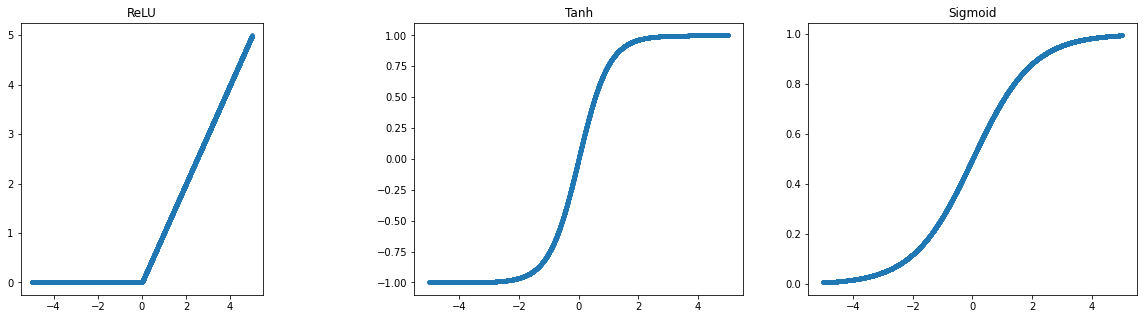

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title('ReLU')
plt.scatter(data, relu(data), marker='.')
plt.subplot(1, 3, 2)
plt.title('Tanh')
plt.scatter(data, tanh(data), marker='.')
plt.subplot(1, 3, 3)
plt.title('Sigmoid')
plt.scatter(data, sigm(data), marker='.')
plt.show();

# Convolutional layer

In [20]:
data = torch.randn(size=(128, 1, 28, 28))

In [21]:
conv = nn.Conv2d(in_channels=1, out_channels=13, kernel_size=3, bias=True)
print(conv)

Conv2d(1, 13, kernel_size=(3, 3), stride=(1, 1))


In [22]:
output = conv(data)
print(output.shape)

torch.Size([128, 13, 26, 26])



$H' = \frac{H - K + 2\cdot P}{S} + 1$

$P=$ padding

$S=$stride



# (almost) Deep Feed Forward Fully Connected Neural Network

In [23]:
model = nn.Sequential(
                nn.Linear(in_features=128, out_features=256, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=10, bias=True)
        )
print(model)

Sequential(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)


In [24]:
model2 = nn.Sequential(
                  OrderedDict([
                        ('lin1', nn.Linear(in_features=128, out_features=256, bias=True)),
                        ('relu1', nn.ReLU()),
                        ('lin2', nn.Linear(in_features=256, out_features=128, bias=True)),
                        ('relu2', nn.ReLU()),
                        ('lin3', nn.Linear(in_features=128, out_features=10, bias=True)),
                  ])
        )
print(model2)
print(model2.lin1)

Sequential(
  (lin1): Linear(in_features=128, out_features=256, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=128, out_features=10, bias=True)
)
Linear(in_features=128, out_features=256, bias=True)


In [25]:
layers = [
        nn.Linear(in_features=128, out_features=256, bias=True),
        nn.Linear(in_features=256, out_features=128, bias=True),
        nn.Linear(in_features=128, out_features=10, bias=True)
]

In [26]:
class MyModel(nn.Module):
    def __init__(self, layers):
        super(MyModel, self).__init__()
        self.relu = nn.ReLU()
        self.layers = layers

    def forward(self, x):
        print("Inside the forward step")
        if x.dim() > 2:
            x = x.reshape(x.shape[0], -1)
        o1 = self.layers[0](x)
        print(f"Shape after fist layer: {o1.shape}")
        o2 = self.relu(o1)
        o3 = self.layers[1](o2)
        print(f"Shape after second layer: {o3.shape}")
        o4 = self.relu(o3)
        o5 = self.layers[2](o4)
        print(f"Shape after last layer: {o5.shape}")
        return o5

In [27]:
model3 = MyModel(layers)
print(model3)

MyModel(
  (relu): ReLU()
)


In [28]:
class MyModel2(nn.Module):
    def __init__(self, layers):
        super(MyModel2, self).__init__()
        self.seq = nn.Sequential(
                            OrderedDict([
                                  ('lin1', layers[0]),
                                  ('relu1', nn.ReLU()),
                                  ('lin2', layers[1]),
                                  ('relu2', nn.ReLU()),
                                  ('lin3', layers[2]),
                            ])
                  )

    def forward(self, x):
        if x.dim() > 2:
            x = x.reshape(x.shape[0], -1)
        return self.seq(x)

In [29]:
model4 = MyModel2(layers)
print(model4)

MyModel2(
  (seq): Sequential(
    (lin1): Linear(in_features=128, out_features=256, bias=True)
    (relu1): ReLU()
    (lin2): Linear(in_features=256, out_features=128, bias=True)
    (relu2): ReLU()
    (lin3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [30]:
model3.to(device), model4.to(device);

In [31]:
input = torch.randn(size=(1, 128), device=device)

In [32]:
model3(input)

Inside the forward step
Shape after fist layer: torch.Size([1, 256])
Shape after second layer: torch.Size([1, 128])
Shape after last layer: torch.Size([1, 10])


tensor([[ 0.0640,  0.0892, -0.0056, -0.0984,  0.1058, -0.2744, -0.1040, -0.0592,
          0.0372, -0.0610]], device='cuda:0', grad_fn=<AddmmBackward>)

In [33]:
model4(input)

tensor([[ 0.0640,  0.0892, -0.0056, -0.0984,  0.1058, -0.2744, -0.1040, -0.0592,
          0.0372, -0.0610]], device='cuda:0', grad_fn=<AddmmBackward>)

# (almost) Deep Convolutional Neural Network

In [34]:
class MyModelConv(nn.Module):
    def __init__(self):
        super(MyModelConv, self).__init__()
        self.relu = nn.ReLU()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, bias=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, bias=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=True)
        self.linear1 = nn.Linear(in_features=128*576, out_features=128, bias=True)
        self.linear2 = nn.Linear(in_features=128, out_features=10, bias=True)
    

    def forward(self, x, avg_pool=False):
        o1 = self.relu(self.conv1(x))
        o2 = self.relu(self.conv2(o1))
        o3 = self.relu(self.conv3(o2))
        o4 = self.relu(self.avg_pool(o3)) if avg_pool else self.relu(self.linear1(o3.view(o3.shape[0], -1)))
        return self.linear2(o4.squeeze())

In [35]:
model_conv = MyModelConv()
model_conv.to(device)
print(model_conv)

MyModelConv(
  (relu): ReLU()
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=73728, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)


In [36]:
output = model_conv(torch.randn((12, 3, 32, 32), device=device), True)
print(output.shape)

torch.Size([12, 10])


# Optimizer

In [37]:
sgd = SGD(params=model_conv.parameters(), lr=1.e-3, momentum=0.9, weight_decay=1.e-4, nesterov=True)
adam = Adam(params=model_conv.parameters(), lr=1.e-3, weight_decay=1.e-4)

# Loss Function

In [38]:
criterion = nn.CrossEntropyLoss()

In [39]:
data = torch.randn(size=(8, 3, 32, 32), device=device)
labels = torch.tensor([0, 4, 2, 3, 1, 6, 3, 7], device=device)

In [40]:
output = model_conv(data)
loss = criterion(output, labels)

In [41]:
print(output.shape)
output_ = nn.Softmax(dim=1)(output)
print(output_.argmax(-1))
print(loss) 

torch.Size([8, 10])
tensor([7, 9, 9, 6, 6, 6, 6, 6], device='cuda:0')
tensor(2.3122, device='cuda:0', grad_fn=<NllLossBackward>)


In [42]:
loss.backward()
sgd.step()